<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>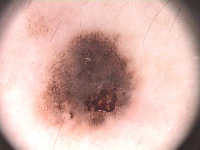</td><td>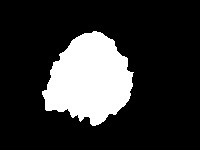</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

# Подготовка данных

In [1]:
!pip install googledrivedownloader

In [2]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [3]:
# Необходимо при запуске на kaggle
!apt install unrar-free -y

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  gnustep-base-common gnustep-base-runtime gnustep-common libgc1c2
  libgnustep-base1.26 libobjc4 libxslt1.1 unar
Suggested packages:
  pike8.0 | pike7.8 | pike7.6 | pike
The following NEW packages will be installed:
  gnustep-base-common gnustep-base-runtime gnustep-common libgc1c2
  libgnustep-base1.26 libobjc4 libxslt1.1 unar unrar-free
0 upgraded, 9 newly installed, 0 to remove and 31 not upgraded.
Need to get 3251 kB of archives.
After this operation, 15.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 gnustep-common amd64 2.7.0-4 [39.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 gnustep-base-common all 1.26.0-7 [70.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/main amd64 libgc1c2 amd64 1:7.6.4-0.4ubuntu1 [83.9 kB]
Get:4 http://archive.ubuntu.com/ubuntu fo

In [4]:
get_ipython().system_raw("unrar x PH2Dataset.rar")


unrar 0.0.1  Copyright (C) 2004  Ben Asselstine, Jeroen Dekkers


Extracting from /kaggle/working/PH2Dataset.rar

Extracting  PH2Dataset/PH2_dataset.txt                                OK        
Extracting  PH2Dataset/PH2_dataset.xlsx                               OK        
Extracting  PH2Dataset/Readme.txt                                     OK        
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_Dermoscopic_Image/IMD002.bmp OK        
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_lesion/IMD002_lesion.bmp OK        
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_roi/IMD002_R1_Label4.bmp OK        
Extracting  PH2Dataset/PH2 Dataset images/IMD002/IMD002_roi/IMD002_R2_Label3.bmp OK        
Extracting  PH2Dataset/PH2 Dataset images/IMD003/IMD003_Dermoscopic_Image/IMD003.bmp OK        
Extracting  PH2Dataset/PH2 Dataset images/IMD003/IMD003_lesion/IMD003_lesion.bmp OK        
Extracting  PH2Dataset/PH2 Dataset images/IMD003/IMD003_roi/IMD003_R1_Label4.bmp O

In [5]:
# Переменные для хранения метрик

ALL_DATA_SEG_NET = {}

ALL_DATA_U_NET = {}

ALL_DATA_U_NET2 = {}

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [6]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [7]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [8]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [9]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

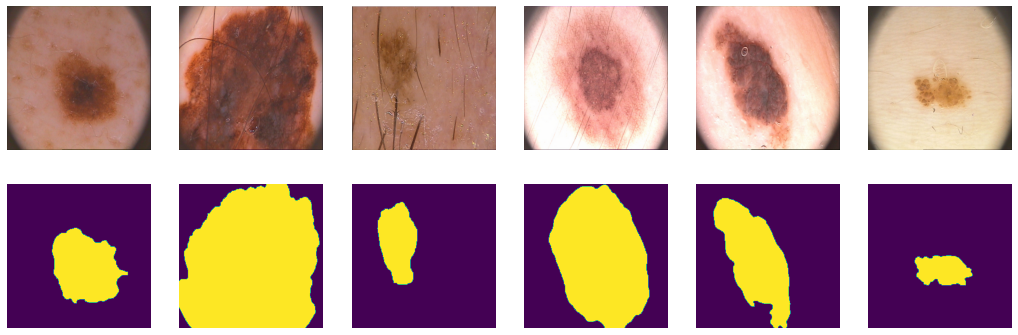

In [10]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [11]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [12]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [13]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [14]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

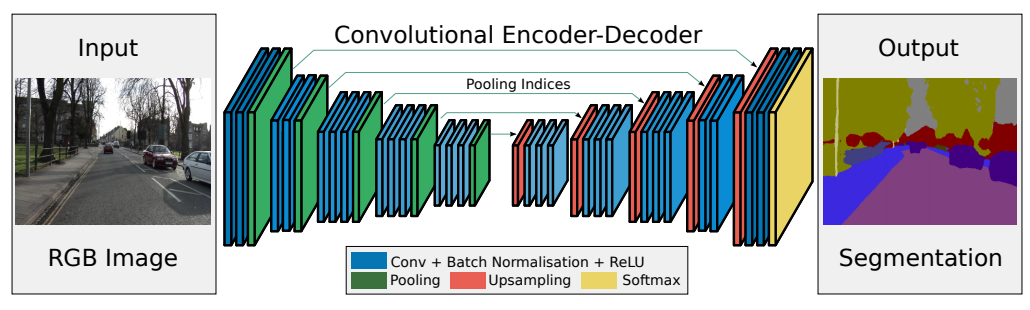

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

В SegNet есть сеть кодировщиков и соответствующая сеть декодеров, за которыми следует последний слой попиксельной классификации.
Эта архитектура проиллюстрирована на рис.3.
Сеть кодера состоит из 13 сверточных слоев, которые соответствуют первым 13 сверточным уровням в сети VGG16 [1], предназначенной для классификации объектов.
Таким образом, мы можем инициализировать процесс обучения с помощью весов, обученных для классификации на больших наборах данных [41].
Мы также можем отказаться от полностью связанных слоев в пользу сохранения функциональных карт с более высоким разрешением на выходе самого глубокого кодировщика.
Это также значительно снижает количество параметров в сети кодировщика SegNet (с 134M до 14,7M) по сравнению с другими недавними архитектурами [2], [4] (см. Таблицу 6).
Каждый уровень кодера имеет соответствующий уровень декодера, и, следовательно, сеть декодера имеет 13 уровней.
Окончательный вывод декодера подается на мульти-классификатор soft-max для получения вероятностей классов для каждого пикселя независимо.

## Реализация SegNet

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [16]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
                                       nn.Conv2d(3,16,3, padding = 1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU(),
                                       nn.Conv2d(16,16,3, padding = 1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU()
                                      )
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                                       nn.Conv2d(16,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(32,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU()
                                       )
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0, return_indices=True)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                                       nn.Conv2d(32,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       )
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0, return_indices=True)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                                       nn.Conv2d(64,128,3, padding = 1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(128,128,3, padding = 1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU()
                                       )
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(128, 128, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size = 2, stride=2, padding=0)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                                       nn.Conv2d(128,128,3, padding = 1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(128,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU()
                                       )
        self.upsample1 = nn.MaxUnpool2d(kernel_size = 2, stride=2, padding=0)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                                       nn.Conv2d(64,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU()
                                       )
        self.upsample2 = nn.MaxUnpool2d(kernel_size = 2, stride=2, padding=0)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                                       nn.Conv2d(32,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(32,16,3, padding = 1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU()
                                       )
        self.upsample3 = nn.MaxUnpool2d(kernel_size = 2, stride=2, padding=0)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                                       nn.Conv2d(16,16,3, padding = 1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU(),
                                       nn.Conv2d(16,1,3, padding = 1),
                                       nn.BatchNorm2d(1)
                                       )

    def forward(self, x):
        # encoder
        x, indices0 = self.pool0(self.enc_conv0(x))
        x, indices1 = self.pool1(self.enc_conv1(x))
        x, indices2 = self.pool2(self.enc_conv2(x))
        x, indices3 = self.pool3(self.enc_conv3(x))

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.dec_conv0(self.upsample0(x, indices3))
        x = self.dec_conv1(self.upsample1(x, indices2))
        x = self.dec_conv2(self.upsample2(x, indices1))
        x = self.dec_conv3(self.upsample3(x, indices0))  # no activation
        
        return x

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [17]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [18]:
def bce_loss(y_real, y_pred):
    # TODO 
    # please don't use nn.BCELoss. write it from scratch
    return torch.mean((y_pred-y_real*y_pred+torch.log(1+torch.exp(-y_pred))))


# def bce_loss(y_real, y_pred):
#     return torch.nn.BCEWithLogitsLoss()(y_real, y_pred)

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [19]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, scheduler):
    X_val, Y_val = next(iter(data_val))
    train_losses = []
    val_losses = []
    iou_score = []
    sum_time = 0

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            Y_pred = model.forward(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward()  # backward-pass
            opt.step()       # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
        toc = time()
        sum_time += toc-tic
        print('loss: {:.3f}, time: {:.3f} s'.format(avg_loss, (toc-tic)))
        train_losses.append(avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().to('cpu')  # detach and put into cpu
        val_losses.append(loss_fn(y_real=Y_val, y_pred=Y_hat))
        iou_score.append(score_model(model, iou_pytorch, data_val))

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='GnBu_r')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        scheduler.step()
    print('time: {:.3f} s'.format(sum_time))
    return train_losses, val_losses, iou_score, sum_time

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [20]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [21]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = model(X_batch.to(device))
        Y_pred = Y_pred > 0.5
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [22]:
!nvidia-smi

Sat Dec  4 15:34:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

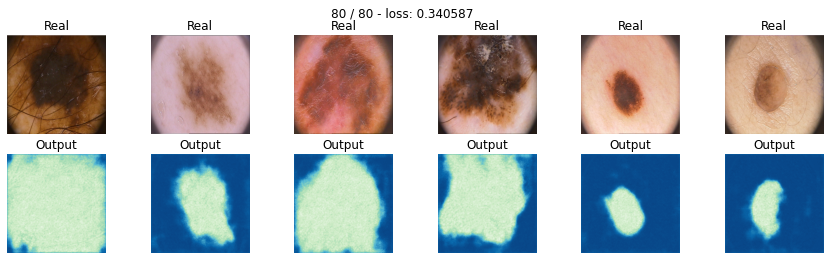

time: 42.090 s
0.648000031709671


In [23]:
# lr=1e-2 - score=0.1720
# lr=1e-3 - score=0.4220 - gamma=0.1
# lr=1e-3 - score=0.6180 - gamma=0.4
# lr=1e-3 - score=0.6600 - gamma=0.7 - step_size=3
# lr=1e-3 - score=0.6600 - gamma=0.7 - step_size=5
# lr=1e-3 - score=0.7080 - gamma=0.7 - step_size=7
# lr=1e-3 - score=0.6340 - gamma=0.9
# lr=1e-4 - score=0.0200

import torch.optim as optim

max_epochs = 80
model = SegNet().to(device)
optim = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=7, gamma=0.7)
bce_train_loss, bce_val_loss, bce_iou, bce_time = train(model=model, 
                                              opt = optim, 
                                              scheduler = scheduler, 
                                              loss_fn = bce_loss, 
                                              epochs = max_epochs, 
                                              data_tr = data_tr, 
                                              data_val = data_val)

print(score_model(model, iou_pytorch, data_val))

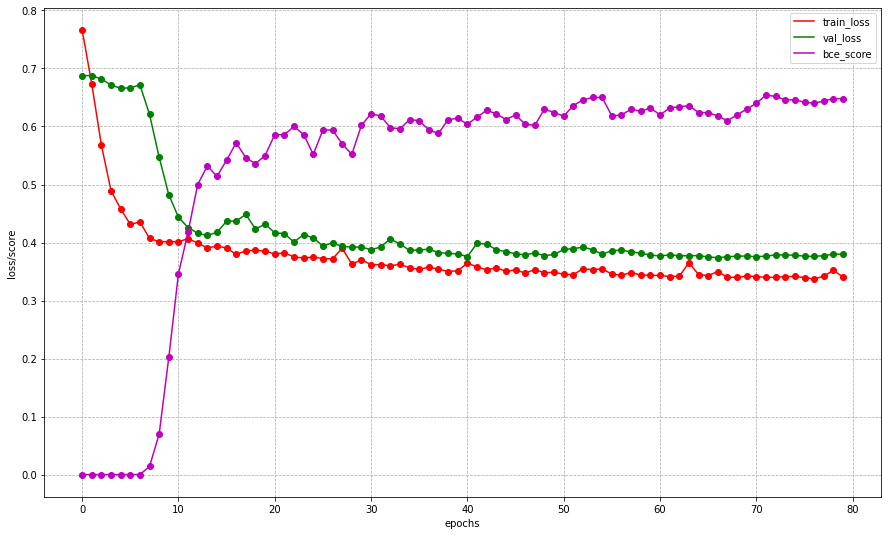

In [24]:
plt.figure(figsize=(15, 9))

plt.plot(bce_train_loss, 'r-', label="train_loss")
plt.plot(bce_train_loss, 'ro')

plt.plot(bce_val_loss, 'g-', label="val_loss")
plt.plot(bce_val_loss, 'go')

plt.plot(bce_iou, 'm-', label="bce_score")
plt.plot(bce_iou, 'mo')

plt.legend(loc='best')
plt.xlabel("epochs")
plt.grid(linestyle='--', linewidth=0.75)
plt.ylabel("loss/score")
plt.show()

In [25]:
ALL_DATA_SEG_NET['bce_loss'] =  {
    'train_loss': sum([i.item() for i in bce_train_loss[-10:]])/10,
    'valid_loss': sum([i.item() for i in bce_val_loss[-10:]])/10,
    'iou_metric': sum([i for i in bce_iou[-10:]])/10,
    'time': bce_time
}

Ответьте себе (не только себе) на вопрос: не переобучается ли моя модель?

Как видно из графика потерь для валидационной выборки модель обучается с текущими гиперпараметрами по всем 80 эпохам. 

Как видно из графика потерь для тренировочной выборки модель очень быстро запоминает выборку - 10 эпоха сигнализирует об этом

График score начинает расти примерно с 7 эпохи и выходит на плато начиная с 50

После 10 эпохи начинается переобучение, так как растет разница между значениями функций потерь для тренировочной и валидационной выборки

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


### Dice coefficient

Best value - 0.6700

**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [26]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    num = 2*torch.sum(y_real * y_pred)
    den = torch.sum(y_real) + torch.sum(y_pred)
    res = 1 - (num+1)/(den+1)
    return res 

Проводим тестирование:

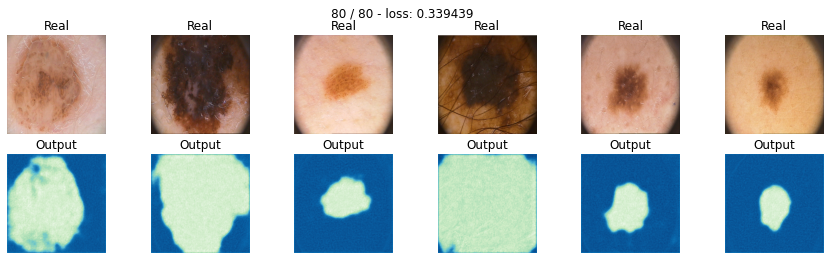

time: 36.768 s
0.6739999949932098


In [27]:
# lr=1e-2 - score=0.3700
# lr=1e-3 - score=0.5820 - gamma=0.1
# lr=1e-3 - score=0.6679 - gamma=0.4
# lr=1e-3 - score=0.6839 - gamma=0.7 - step_size=3
# lr=1e-3 - score=0.6880 - gamma=0.7 - step_size=5
# lr=1e-3 - score=0.7000 - gamma=0.7 - step_size=7
# lr=1e-3 - score=0.6719 - gamma=0.9
# lr=1e-4 - score=0.0800

import torch.optim as optim

model_dice = SegNet().to(device)

max_epochs = 80
optimaizer = optim.Adam(model_dice.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=7, gamma=0.7)
dice_train_loss, dice_val_loss, dice_iou, dice_time = train(model=model_dice, 
                                              opt = optimaizer, 
                                              scheduler = scheduler, 
                                              loss_fn = dice_loss, 
                                              epochs = max_epochs, 
                                              data_tr = data_tr, 
                                              data_val = data_val)

print(score_model(model_dice, iou_pytorch, data_val))

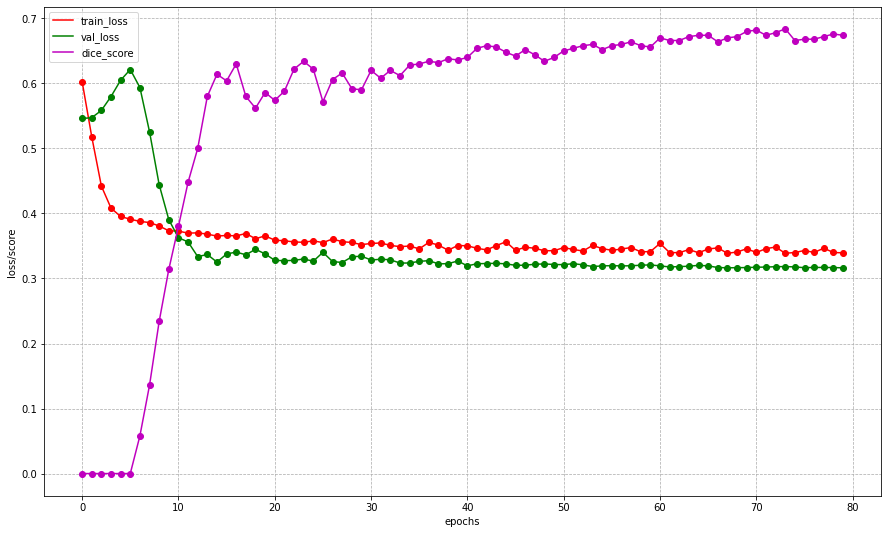

In [28]:
plt.figure(figsize=(15, 9))

plt.plot(dice_train_loss, 'r-', label="train_loss")
plt.plot(dice_train_loss, 'ro')

plt.plot(dice_val_loss, 'g-', label="val_loss")
plt.plot(dice_val_loss, 'go')

plt.plot(dice_iou, 'm-', label="dice_score")
plt.plot(dice_iou, 'mo')

plt.legend(loc='best')
plt.xlabel("epochs")
plt.grid(linestyle='--', linewidth=0.75)
plt.ylabel("loss/score")
plt.show()

In [29]:
ALL_DATA_SEG_NET['dice_loss'] =  {
    'train_loss': sum([i.item() for i in dice_train_loss[-10:]])/10,
    'valid_loss': sum([i.item() for i in dice_val_loss[-10:]])/10,
    'iou_metric': sum([i for i in dice_iou[-10:]])/10,
    'time': dice_time
}

Как видно из графика потерь для валидационной выборки модель обучается с текущими гиперпараметрами по всем 80 эпохам. 

Как видно из графика потерь для тренировочной выборки модель очень быстро запоминает выборку - 10 эпоха сигнализирует об этом

График score начинает расти примерно с 7 эпохи и выходит на плато начиная с 60

После 10 эпохи начинается интересное событие - значения функций потерь уменьшается, но на валидационной выборке на протяжении всего обучения значения меньше. Возможно это связано с тем, что выборки невелики и найденные коэффициенты довольно хороши

### Focal loss

Best value - 0.6500

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [30]:
def focal_loss(y_real, y_pred, eps = 1e-3, gamma = 2):

    y_prob =  torch.clamp(torch.sigmoid(y_pred), min=eps, max=1-eps)
    return -torch.mean((1 - y_prob) ** gamma * y_real * torch.log(y_prob) + 
                       (1 - y_real) * torch.log(1 - y_prob))


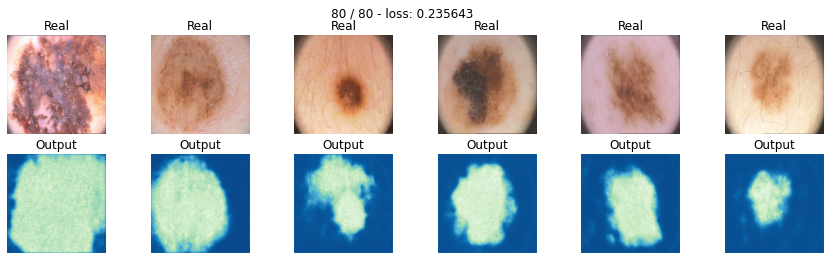

time: 36.990 s
0.628000020980835


In [31]:
# lr=1e-1 - score=0.1279
# lr=1e-2 - score=0.2199
# lr=1e-3 - score=0.2700 - gamma=0.1
# lr=1e-3 - score=0.5380 - gamma=0.4
# lr=1e-3 - score=0.5600 - gamma=0.7
# lr=1e-3 - score=0.5299 - gamma=0.9 - step_size=3
# lr=1e-3 - score=0.6839 - gamma=0.9 - step_size=5
# lr=1e-3 - score=0.6579 - gamma=0.9 - step_size=7
# lr=1e-4 - score=0

model_focal = SegNet().to(device)

max_epochs = 80

optimaizer = optim.Adam(model_focal.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=5, gamma=0.9)

focal_train_loss, focal_val_loss, focal_iou, focal_time = train(model=model_focal, 
                                              opt = optimaizer, 
                                              scheduler = scheduler, 
                                              loss_fn = focal_loss, 
                                              epochs = max_epochs, 
                                              data_tr = data_tr, 
                                              data_val = data_val)

print(score_model(model_focal, iou_pytorch, data_val))

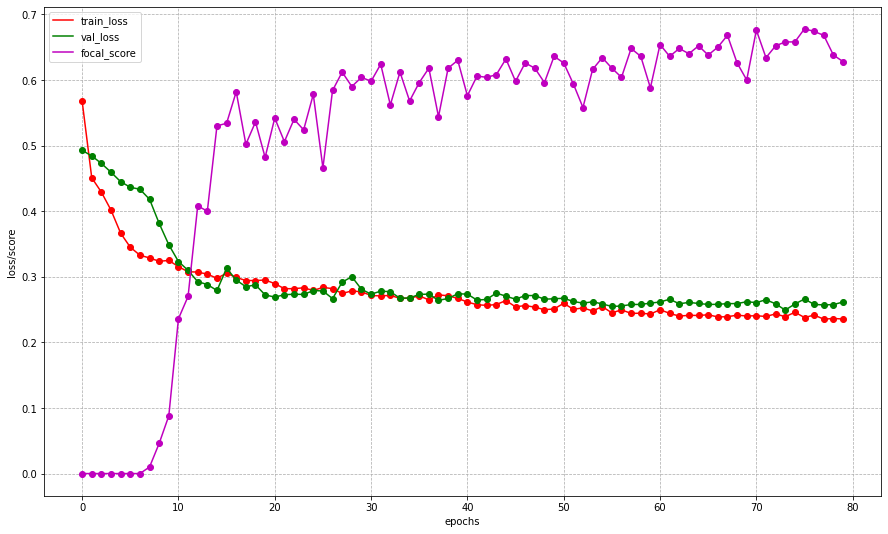

In [32]:
plt.figure(figsize=(15, 9))

plt.plot(focal_train_loss, 'r-', label="train_loss")
plt.plot(focal_train_loss, 'ro')

plt.plot(focal_val_loss, 'g-', label="val_loss")
plt.plot(focal_val_loss, 'go')

plt.plot(focal_iou, 'm-', label="focal_score")
plt.plot(focal_iou, 'mo')

plt.legend(loc='best')
plt.xlabel("epochs")
plt.grid(linestyle='--', linewidth=0.75)
plt.ylabel("loss/score")
plt.show()

In [33]:
ALL_DATA_SEG_NET['focal_loss'] =  {
    'train_loss': sum([i.item() for i in focal_train_loss[-10:]])/10,
    'valid_loss': sum([i.item() for i in focal_val_loss[-10:]])/10,
    'iou_metric': sum([i for i in focal_iou[-10:]])/10,
    'time': focal_time
}

Как видно из графика потерь для валидационной выборки модель обучается с текущими гиперпараметрами по всем 80 эпохам. 
(Можно аппроксимировать линейной зависимостью с 20 по 80 эпохи и увидеть, что угол между осью 0х и данной прямой в диапазоне [0,90])

Как видно из графика потерь для тренировочной выборки модель очень быстро запоминает выборку - 10 эпоха сигнализирует об этом

Переобучения скорее всего нет. Судя по значениям score данная метрика не устойчива на данном наборе данных 

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

### Tversky Loss

Best value - 0.7520

In [34]:
def tversky_loss(y_real, y_pred, smooth=1, alpha=0.3, beta=0.7):

    y_pred = F.sigmoid(y_pred) 

    TP = (y_pred * y_real).sum()    
    FP = ((1-y_real) * y_pred).sum()
    FN = (y_real * (1-y_pred)).sum()

    Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  

    return 1 - Tversky

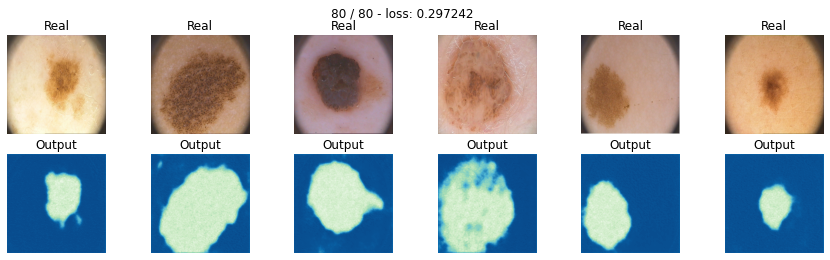

time: 36.842 s
0.6880000233650208


In [35]:
# lr=1e-2 - score=0.5780
# lr=1e-3 - score=0.6540 - gamma=0.1
# lr=1e-3 - score=0.6560 - gamma=0.4
# lr=1e-3 - score=0.7260 - gamma=0.7 - step_size=3
# lr=1e-3 - score=0.7520 - gamma=0.7 - step_size=5
# lr=1e-3 - score=0.7479 - gamma=0.7 - step_size=7
# lr=1e-3 - score=0.7040 - gamma=0.9
# lr=1e-4 - score=0.1500

model_tversky = SegNet().to(device)

max_epochs = 80

optimaizer = optim.Adam(model_tversky.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=5, gamma=0.7)

tversky_train_loss, tversky_val_loss, tversky_iou, tversky_time = train(model=model_tversky, 
                                              opt = optimaizer, 
                                              scheduler = scheduler, 
                                              loss_fn = tversky_loss, 
                                              epochs = max_epochs, 
                                              data_tr = data_tr, 
                                              data_val = data_val)

print(score_model(model_tversky, iou_pytorch, data_val))

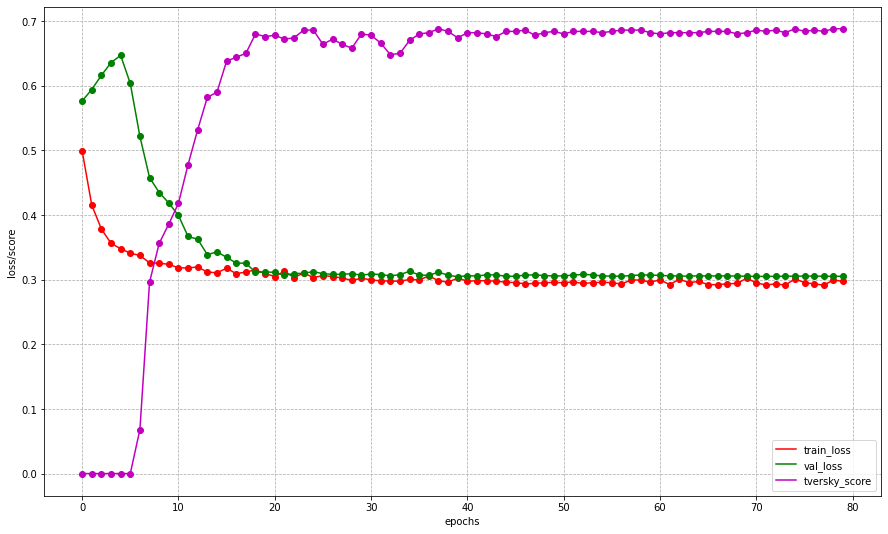

In [36]:
plt.figure(figsize=(15, 9))

plt.plot(tversky_train_loss, 'r-', label="train_loss")
plt.plot(tversky_train_loss, 'ro')

plt.plot(tversky_val_loss, 'g-', label="val_loss")
plt.plot(tversky_val_loss, 'go')

plt.plot(tversky_iou, 'm-', label="tversky_score")
plt.plot(tversky_iou, 'mo')

plt.legend(loc='best')
plt.xlabel("epochs")
plt.grid(linestyle='--', linewidth=0.75)
plt.ylabel("loss/score")
plt.show()

In [37]:
ALL_DATA_SEG_NET['tversky_loss'] =  {
    'train_loss': sum([i.item() for i in tversky_train_loss[-10:]])/10,
    'valid_loss': sum([i.item() for i in tversky_val_loss[-10:]])/10,
    'iou_metric': sum([i for i in tversky_iou[-10:]])/10,
    'time': tversky_time
}

Как видно из графика потерь для валидационной выборки модель обучается с текущими гиперпараметрами примерно до эпохи 30. Далее выходит на плато

Как видно из графика потерь для тренировочной выборки модель запоминает выборку - 20 эпоха сигнализирует об этом

Переобучения скорее всего нет. Судя по значениям score данная метрика оказалась более устойчивой на текущих данных, имеет маленький разброс между значениями функций потерь на тренировочной и валидационной выборками

### Tversky focal loss

Best value - 0.7640

In [38]:
def tversky_focal_loss(y_real, y_pred, smooth=1, alpha=0.3, beta=0.7, gamma=2):

    y_pred = F.sigmoid(y_pred) 
    y_pred = y_pred.view(-1)
    y_real = y_real.view(-1)

    TP = (y_pred * y_real).sum()    
    FP = ((1-y_real) * y_pred).sum()
    FN = (y_real * (1-y_pred)).sum()

    Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
    FocalTversky = (1 - Tversky)**gamma

    return FocalTversky

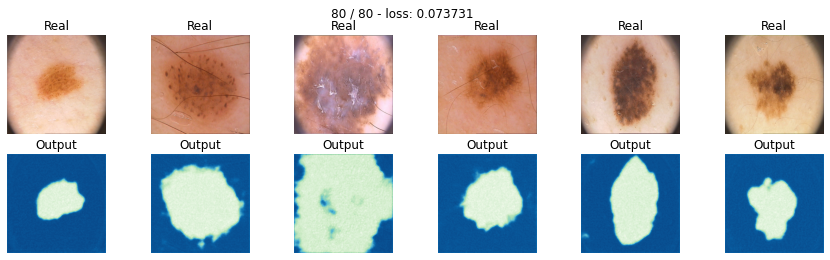

time: 37.017 s
0.7519999742507935


In [39]:
# lr=1e-2 - score=0.6000
# lr=1e-3 - score=0.6500 - gamma=0.1
# lr=1e-3 - score=0.7040 - gamma=0.4
# lr=1e-3 - score=0.7280 - gamma=0.7
# lr=1e-3 - score=0.7500 - gamma=0.9 - step_size=3
# lr=1e-3 - score=0.7640 - gamma=0.9 - step_size=5
# lr=1e-3 - score=0.7280 - gamma=0.9 - step_size=5
# lr=1e-4 - score=0.1880

model_tversky_focal = SegNet().to(device)

max_epochs = 80

optimaizer = optim.Adam(model_tversky_focal.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=5, gamma=0.9)

(tversky_focal_train_loss, tversky_focal_val_loss, tversky_focal_iou, 
 tversky_focal_time) = train(model=model_tversky_focal, 
                                              opt = optimaizer, 
                                              scheduler = scheduler, 
                                              loss_fn = tversky_focal_loss, 
                                              epochs = max_epochs, 
                                              data_tr = data_tr, 
                                              data_val = data_val)

print(score_model(model_tversky_focal, iou_pytorch, data_val))

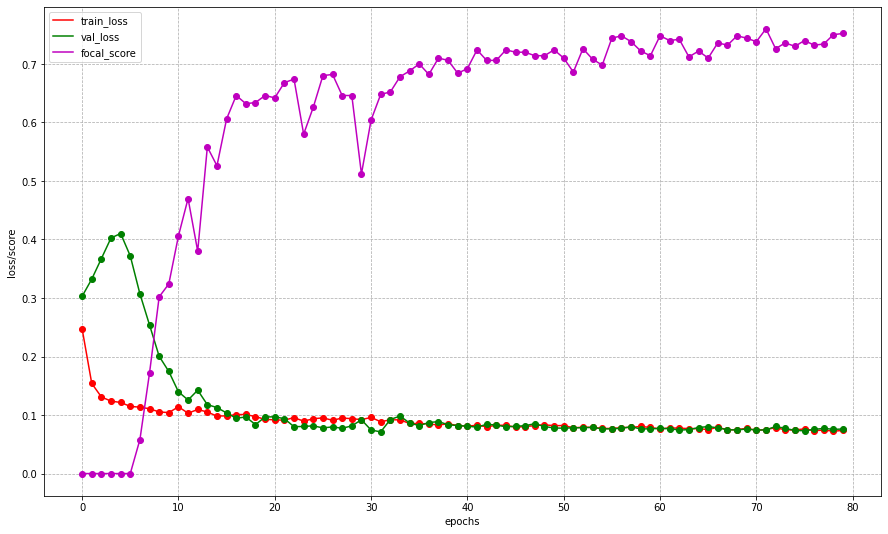

In [40]:
plt.figure(figsize=(15, 9))

plt.plot(tversky_focal_train_loss, 'r-', label="train_loss")
plt.plot(tversky_focal_train_loss, 'ro')

plt.plot(tversky_focal_val_loss, 'g-', label="val_loss")
plt.plot(tversky_focal_val_loss, 'go')

plt.plot(tversky_focal_iou, 'm-', label="focal_score")
plt.plot(tversky_focal_iou, 'mo')

plt.legend(loc='best')
plt.xlabel("epochs")
plt.grid(linestyle='--', linewidth=0.75)
plt.ylabel("loss/score")
plt.show()

In [41]:
ALL_DATA_SEG_NET['tversky_focal_loss'] =  {
    'train_loss': sum([i.item() for i in tversky_focal_train_loss[-10:]])/10,
    'valid_loss': sum([i.item() for i in tversky_focal_val_loss[-10:]])/10,
    'iou_metric': sum([i for i in tversky_focal_iou[-10:]])/10,
    'time': tversky_focal_time
}

Как видно из графика потерь для валидационной выборки модель обучается с текущими гиперпараметрами на всех 80 эпохах

Как видно из графика потерь для тренировочной выборки модель быстро запоминает выборку - 10 эпоха сигнализирует об этом

Переобучения нет, так как графики функции потерь на тренировочной и валидационной выборках практически совпадают. Судя по значениям score данная метрика оказалась не устойчивой на данном наборе данных, как и метрика focal_loss.

### Topology-Preserving Deep Image Segmentation

https://github.com/HuXiaoling/TopoLoss

Хотел разобрать эту метрику и нашел, как я понимаю, реализацию от автора предложенной статьи, но не хватило времени

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

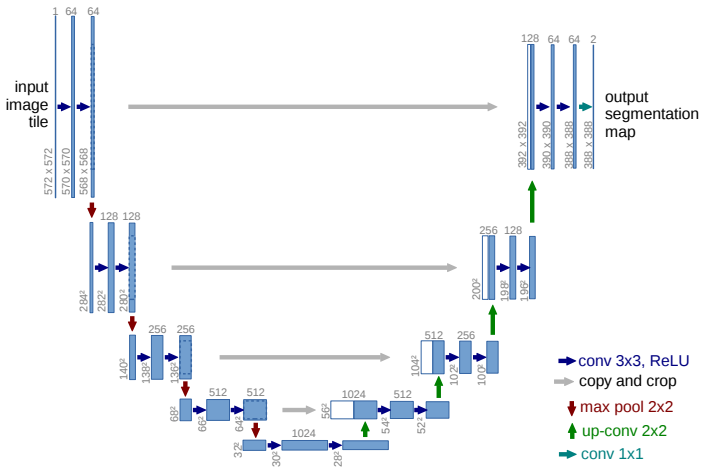

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

### Реализация модели U-Net

In [42]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
                                       nn.Conv2d(3,16,3, padding = 1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU(),
                                       nn.Conv2d(16,16,3, padding = 1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU()
                                      )
        self.pool0 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0, return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                                       nn.Conv2d(16,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(32,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU()
                                       )
        self.pool1 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0, return_indices=True)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                                       nn.Conv2d(32,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       )
        self.pool2 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0, return_indices=True)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                                       nn.Conv2d(64,128,3, padding = 1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(128,128,3, padding = 1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU()
                                       )
        self.pool3 = nn.MaxPool2d(kernel_size = 2, stride=2, padding=0, return_indices=True)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(128, 128, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size = 2, stride=2, padding=0)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                                       nn.Conv2d(128*2,128,3, padding = 1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(128,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU()
                                       )
        self.upsample1 = nn.MaxUnpool2d(kernel_size = 2, stride=2, padding=0)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                                       nn.Conv2d(64*2,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU()
                                       )
        self.upsample2 = nn.MaxUnpool2d(kernel_size = 2, stride=2, padding=0)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                                       nn.Conv2d(32*2,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(32,16,3, padding = 1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU()
                                       )
        self.upsample3 = nn.MaxUnpool2d(kernel_size = 2, stride=2, padding=0)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                                       nn.Conv2d(16*2,16,3, padding = 1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU(),
                                       nn.Conv2d(16,1,3, padding = 1),
                                       nn.BatchNorm2d(1)
                                       )

    def forward(self, x):
        # encoder
        conv0 = self.enc_conv0(x)
        x, indices0 = self.pool0(conv0)
        conv1 = self.enc_conv1(x)
        x, indices1 = self.pool1(conv1)
        conv2 = self.enc_conv2(x)
        x, indices2 = self.pool2(conv2)
        conv3 = self.enc_conv3(x)
        x, indices3 = self.pool3(conv3)

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.dec_conv0(torch.cat([self.upsample0(x, indices3), conv3], 1))
        x = self.dec_conv1(torch.cat([self.upsample1(x, indices2), conv2], 1))
        x = self.dec_conv2(torch.cat([self.upsample2(x, indices1), conv1], 1))
        x = self.dec_conv3(torch.cat([self.upsample3(x, indices0), conv0], 1))
        
        return x

### Обучение модели с функцией потерь tversky_loss

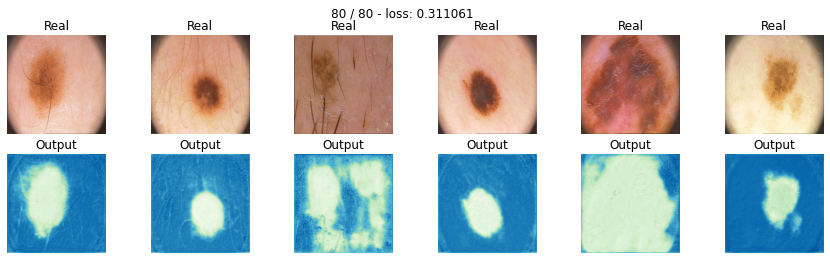

time: 39.630 s
0.6699999868869781


In [43]:
# lr=1e-2 - score=0.6320
# lr=1e-3 - score=0.7120 - gamma=0.1
# lr=1e-3 - score=0.6860 - gamma=0.4 - step_size=3
# lr=1e-3 - score=0.7780 - gamma=0.4 - step_size=5
# lr=1e-3 - score=0.7480 - gamma=0.4 - step_size=7
# lr=1e-3 - score=0.7260 - gamma=0.7
# lr=1e-4 - score=0.2940

import torch.optim as optim

unet_model = UNet().to(device)

max_epochs = 80

optimaizer = optim.Adam(unet_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=5, gamma=0.4)

unet_train_loss, unet_val_loss, unet_iou, unet_time = train(model=unet_model, 
                                              opt = optimaizer, 
                                              scheduler = scheduler, 
                                              loss_fn = tversky_loss, 
                                              epochs = max_epochs, 
                                              data_tr = data_tr, 
                                              data_val = data_val)

print(score_model(unet_model, iou_pytorch, data_val))

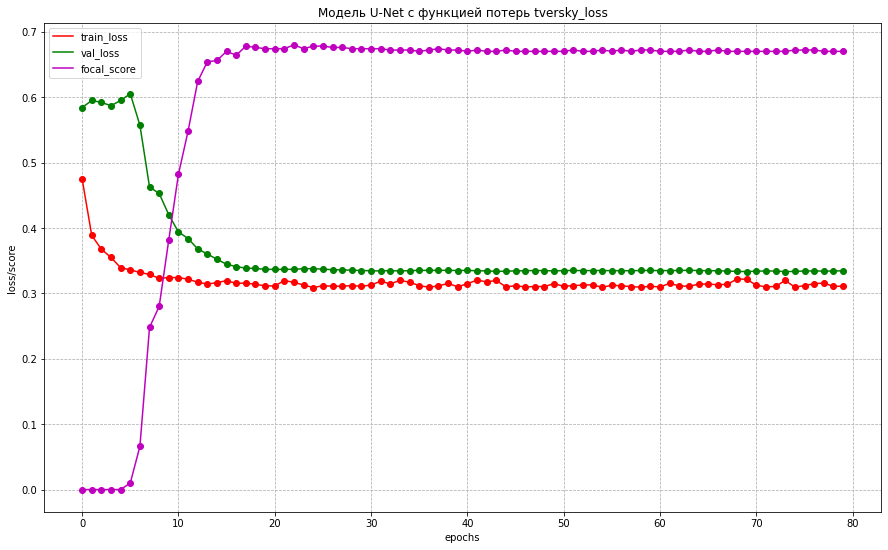

In [44]:
plt.figure(figsize=(15, 9))

plt.plot(unet_train_loss, 'r-', label="train_loss")
plt.plot(unet_train_loss, 'ro')

plt.plot(unet_val_loss, 'g-', label="val_loss")
plt.plot(unet_val_loss, 'go')

plt.plot(unet_iou, 'm-', label="focal_score")
plt.plot(unet_iou, 'mo')
plt.title('Модель U-Net c функцией потерь tversky_loss')
plt.legend(loc='best')
plt.xlabel("epochs")
plt.grid(linestyle='--', linewidth=0.75)
plt.ylabel("loss/score")
plt.show()

In [45]:
ALL_DATA_U_NET['tversky_loss'] =  {
    'train_loss': sum([i.item() for i in unet_train_loss[-10:]])/10,
    'valid_loss': sum([i.item() for i in unet_val_loss[-10:]])/10,
    'iou_metric': sum([i for i in unet_iou[-10:]])/10,
    'time': unet_time
}

Значение score достигает максимума примерно на 20 эпохе и далее выходит на плато

### Обучение модели с функцией потерь tversky_focal_loss

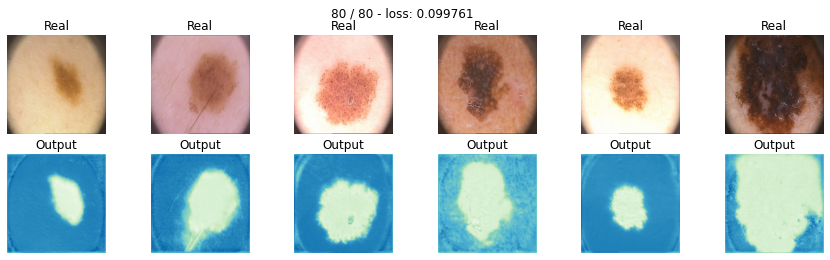

time: 39.677 s
0.6700000166893005


In [46]:
# lr=1e-2 - score=0.3279
# lr=1e-2 - score=0.6220
# lr=1e-3 - score=0.6400 - gamma=0.1
# lr=1e-3 - score=0.6579 - gamma=0.4 - step_size=3
# lr=1e-3 - score=0.7539 - gamma=0.4 - step_size=5
# lr=1e-3 - score=0.6999 - gamma=0.4 - step_size=7
# lr=1e-3 - score=0.7240 - gamma=0.4 - step_size=9
# lr=1e-3 - score=0.7080 - gamma=0.7
# lr=1e-4 - score=0.3980

import torch.optim as optim

unet_model = UNet().to(device)

max_epochs = 80

optimaizer = optim.Adam(unet_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=5, gamma=0.4)

unet_train_loss, unet_val_loss, unet_iou, unet_time = train(model=unet_model, 
                                              opt = optimaizer, 
                                              scheduler = scheduler, 
                                              loss_fn = tversky_focal_loss, 
                                              epochs = max_epochs, 
                                              data_tr = data_tr, 
                                              data_val = data_val)

print(score_model(unet_model, iou_pytorch, data_val))

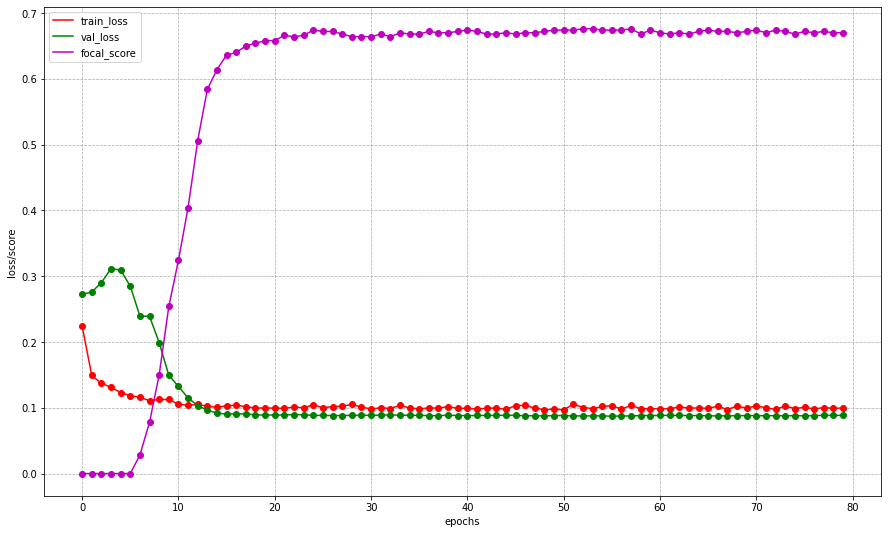

In [47]:
plt.figure(figsize=(15, 9))

plt.plot(unet_train_loss, 'r-', label="train_loss")
plt.plot(unet_train_loss, 'ro')

plt.plot(unet_val_loss, 'g-', label="val_loss")
plt.plot(unet_val_loss, 'go')

plt.plot(unet_iou, 'm-', label="focal_score")
plt.plot(unet_iou, 'mo')

plt.legend(loc='best')
plt.xlabel("epochs")
plt.grid(linestyle='--', linewidth=0.75)
plt.ylabel("loss/score")
plt.show()

In [48]:
ALL_DATA_U_NET['tversky_focal_loss'] =  {
    'train_loss': sum([i.item() for i in unet_train_loss[-10:]])/10,
    'valid_loss': sum([i.item() for i in unet_val_loss[-10:]])/10,
    'iou_metric': sum([i for i in unet_iou[-10:]])/10,
    'time': unet_time
}

Значение score достигает максимума примерно на 25 эпохе и далее выходит на плато

### Обучение модели с функцией потерь focal_loss

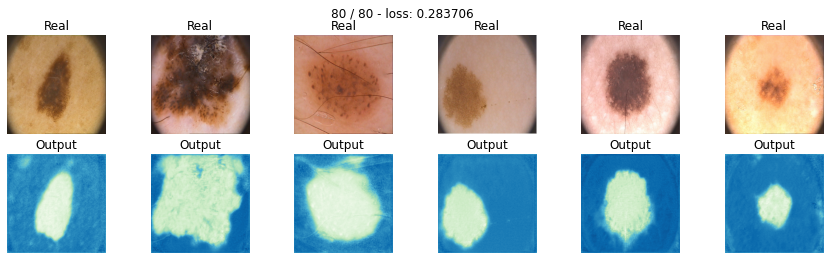

time: 39.759 s
0.6739999949932098


In [49]:
# lr=1e-2 - score=0.4200
# lr=1e-3 - score=0.6719 - gamma=0.1
# lr=1e-3 - score=0.5479 - gamma=0.4
# lr=1e-3 - score=0.6640 - gamma=0.7
# lr=1e-3 - score=0.7179 - gamma=0.9 - step_size=1
# lr=1e-3 - score=0.7019 - gamma=0.9 - step_size=3
# lr=1e-3 - score=0.6719 - gamma=0.9 - step_size=5
# lr=1e-3 - score=0.6039 - gamma=0.9 - step_size=7
# lr=1e-4 - score=0.2480

import torch.optim as optim

unet_model = UNet().to(device)

max_epochs = 80

optimaizer = optim.Adam(unet_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=1, gamma=0.9)

unet_train_loss, unet_val_loss, unet_iou, unet_time = train(model=unet_model, 
                                              opt = optimaizer, 
                                              scheduler = scheduler, 
                                              loss_fn = focal_loss, 
                                              epochs = max_epochs, 
                                              data_tr = data_tr, 
                                              data_val = data_val)

print(score_model(unet_model, iou_pytorch, data_val))

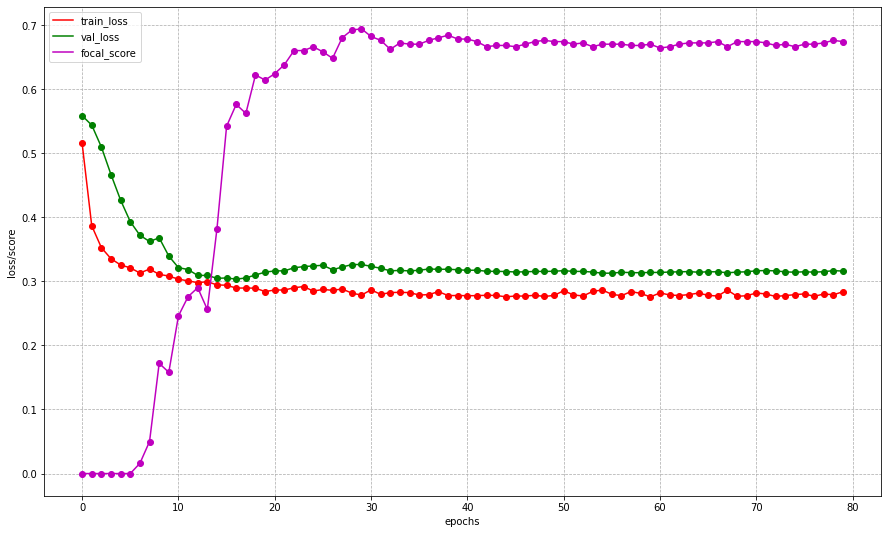

In [50]:
plt.figure(figsize=(15, 9))

plt.plot(unet_train_loss, 'r-', label="train_loss")
plt.plot(unet_train_loss, 'ro')

plt.plot(unet_val_loss, 'g-', label="val_loss")
plt.plot(unet_val_loss, 'go')

plt.plot(unet_iou, 'm-', label="focal_score")
plt.plot(unet_iou, 'mo')

plt.legend(loc='best')
plt.xlabel("epochs")
plt.grid(linestyle='--', linewidth=0.75)
plt.ylabel("loss/score")
plt.show()

In [51]:
ALL_DATA_U_NET['focal_loss'] =  {
    'train_loss': sum([i.item() for i in unet_train_loss[-10:]])/10,
    'valid_loss': sum([i.item() for i in unet_val_loss[-10:]])/10,
    'iou_metric': sum([i for i in unet_iou[-10:]])/10,
    'time': unet_time
}

Значение score достигает максимума примерно на 25-30 эпохе и далее выходит на плато

### Обучение модели с функцией потерь dice_loss

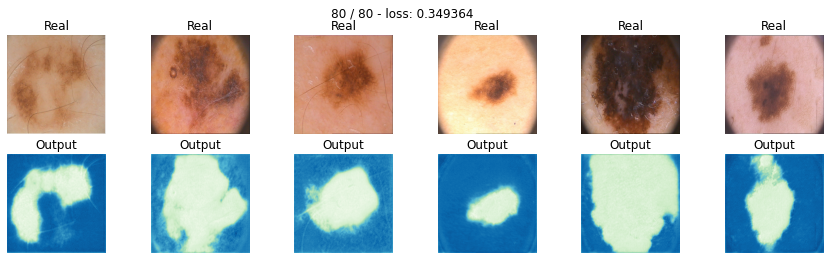

time: 39.543 s
0.7120000422000885


In [52]:
# lr=1e-2 - score=0.6200
# lr=1e-3 - score=0.7339 - gamma=0.1
# lr=1e-3 - score=0.6360 - gamma=0.4 - step_size=3
# lr=1e-3 - score=0.6719 - gamma=0.4 - step_size=5
# lr=1e-3 - score=0.6840 - gamma=0.4 - step_size=7
# lr=1e-3 - score=0.7220 - gamma=0.4 - step_size=9
# lr=1e-3 - score=0.6620 - gamma=0.7
# lr=1e-3 - score=0.6660 - gamma=0.9
# lr=1e-4 - score=0.1779

import torch.optim as optim

unet_model = UNet().to(device)

max_epochs = 80

optimaizer = optim.Adam(unet_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=9, gamma=0.4)

unet_train_loss, unet_val_loss, unet_iou, unet_time = train(model=unet_model, 
                                              opt = optimaizer, 
                                              scheduler = scheduler, 
                                              loss_fn = dice_loss, 
                                              epochs = max_epochs, 
                                              data_tr = data_tr, 
                                              data_val = data_val)

print(score_model(unet_model, iou_pytorch, data_val))

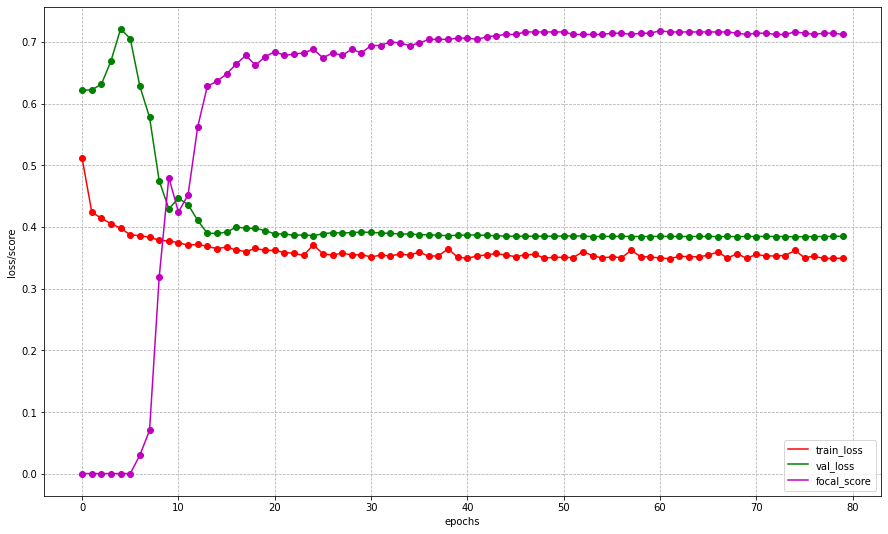

In [53]:
plt.figure(figsize=(15, 9))

plt.plot(unet_train_loss, 'r-', label="train_loss")
plt.plot(unet_train_loss, 'ro')

plt.plot(unet_val_loss, 'g-', label="val_loss")
plt.plot(unet_val_loss, 'go')

plt.plot(unet_iou, 'm-', label="focal_score")
plt.plot(unet_iou, 'mo')

plt.legend(loc='best')
plt.xlabel("epochs")
plt.grid(linestyle='--', linewidth=0.75)
plt.ylabel("loss/score")
plt.show()

In [54]:
ALL_DATA_U_NET['dice_loss'] =  {
    'train_loss': sum([i.item() for i in unet_train_loss[-10:]])/10,
    'valid_loss': sum([i.item() for i in unet_val_loss[-10:]])/10,
    'iou_metric': sum([i for i in unet_iou[-10:]])/10,
    'time': unet_time
}

Значение score достигает максимума примерно на 40 эпохе и далее выходит на плато

В модели присутствует skip-connection, благодаря которому все функции потерь обучаются более плавно, без сильного разброса в зависимости от номера эпохи. Причем достигаемое качество довольно хорошее

# U-Net2

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


### Реализация модели U-Net2

In [55]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
                                       nn.Conv2d(3,16,3, padding = 1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU(),
                                       nn.Conv2d(16,16,3, padding = 1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU()
                                      )
        self.pool0 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(
                                       nn.Conv2d(16,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(32,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU()
                                       )
        self.pool1 = nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Sequential(
                                       nn.Conv2d(32,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       )
        self.pool2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Sequential(
                                       nn.Conv2d(64,128,3, padding = 1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(128,128,3, padding = 1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU()
                                       )
        self.pool3 = nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(128, 128, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
                                       nn.Conv2d(128*2,128,3, padding = 1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(),
                                       nn.Conv2d(128,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU()
                                       )
        self.upsample1 = nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1)  # 32 -> 64
        self.dec_conv1 = nn.Sequential(
                                       nn.Conv2d(64*2,64,3, padding = 1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(),
                                       nn.Conv2d(64,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU()
                                       )
        self.upsample2 = nn.ConvTranspose2d(32, 32, kernel_size=3, stride=2, padding=1)   # 64 -> 128
        self.dec_conv2 = nn.Sequential(
                                       nn.Conv2d(32*2,32,3, padding = 1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(),
                                       nn.Conv2d(32,16,3, padding = 1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU()
                                       )
        self.upsample3 = nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1)   # 128 -> 256
        self.dec_conv3 = nn.Sequential(
                                       nn.Conv2d(16*2,16,3, padding = 1),
                                       nn.BatchNorm2d(16),
                                       nn.ReLU(),
                                       nn.Conv2d(16,1,3, padding = 1),
                                       nn.BatchNorm2d(1)
                                       )

    def forward(self, x):
        # encoder
        conv0 = self.enc_conv0(x)
        x = self.pool0(conv0)
        conv1 = self.enc_conv1(x)
        x = self.pool1(conv1)
        conv2 = self.enc_conv2(x)
        x = self.pool2(conv2)
        conv3 = self.enc_conv3(x)
        x = self.pool3(conv3)

        # bottleneck
        x = self.bottleneck_conv(x)

        # decoder
        x = self.dec_conv0(torch.cat([self.upsample0(x, output_size=conv3.size()), conv3], 1))
        x = self.dec_conv1(torch.cat([self.upsample1(x, output_size=conv2.size()), conv2], 1))
        x = self.dec_conv2(torch.cat([self.upsample2(x, output_size=conv1.size()), conv1], 1))
        x = self.dec_conv3(torch.cat([self.upsample3(x, output_size=conv0.size()), conv0], 1))
        
        return x


In [56]:
unet2_model = UNet2().to(device)
model

SegNet(
  (enc_conv0): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv1): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc_conv2): Sequential(
    (0): Con

In [57]:
# train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 5, data_tr, data_val)

### Обучение модели с функцией потерь tversky_loss

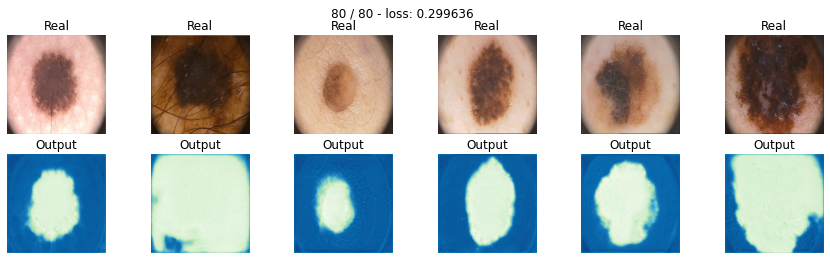

time: 45.063 s
0.6459999680519104


In [58]:
# lr=1e-2 - score=0.5480
# lr=1e-3 - score=0.5979 - gamma=0.1
# lr=1e-3 - score=0.6620 - gamma=0.4
# lr=1e-3 - score=0.7019 - gamma=0.7 - step_size=3
# lr=1e-3 - score=0.7060 - gamma=0.7 - step_size=5
# lr=1e-3 - score=0.7000 - gamma=0.7 - step_size=7
# lr=1e-3 - score=0.7019 - gamma=0.9
# lr=1e-4 - score=0.1680

import torch.optim as optim

unet2_model = UNet2().to(device)

max_epochs = 80

optimaizer = optim.Adam(unet2_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=5, gamma=0.7)

unet_train_loss, unet_val_loss, unet_iou, unet_time = train(model=unet2_model, 
                                              opt = optimaizer, 
                                              scheduler = scheduler, 
                                              loss_fn = tversky_loss, 
                                              epochs = max_epochs, 
                                              data_tr = data_tr, 
                                              data_val = data_val)

print(score_model(unet2_model, iou_pytorch, data_val))

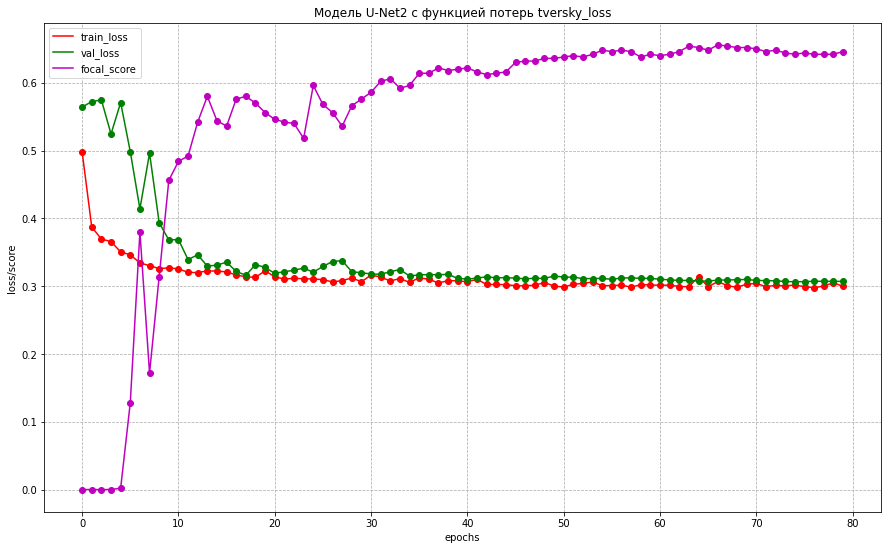

In [59]:
plt.figure(figsize=(15, 9))

plt.plot(unet_train_loss, 'r-', label="train_loss")
plt.plot(unet_train_loss, 'ro')

plt.plot(unet_val_loss, 'g-', label="val_loss")
plt.plot(unet_val_loss, 'go')

plt.plot(unet_iou, 'm-', label="focal_score")
plt.plot(unet_iou, 'mo')

plt.legend(loc='best')
plt.title('Модель U-Net2 c функцией потерь tversky_loss')
plt.xlabel("epochs")
plt.grid(linestyle='--', linewidth=0.75)
plt.ylabel("loss/score")
plt.show()

In [60]:
ALL_DATA_U_NET2['tversky_loss'] =  {
    'train_loss': sum([i.item() for i in unet_train_loss[-10:]])/10,
    'valid_loss': sum([i.item() for i in unet_val_loss[-10:]])/10,
    'iou_metric': sum([i for i in unet_iou[-10:]])/10,
    'time': unet_time
}

Значение score достигает максимума примерно на 50 эпохе и далее выходит на плато

### Обучение модели с функцией потерь tversky_focal_loss

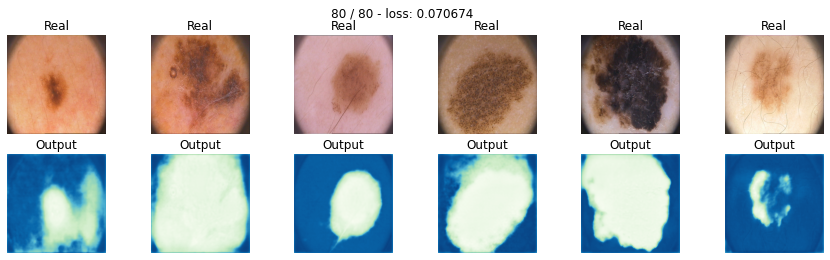

time: 45.298 s
0.5539999902248383


In [61]:
# lr=1e-2 - score=0.5819 - gamma=0.1
# lr=1e-2 - score=0.6200 - gamma=0.4 - step_size=3
# lr=1e-2 - score=0.6140 - gamma=0.4 - step_size=5
# lr=1e-2 - score=0.6259 - gamma=0.4 - step_size=7
# lr=1e-2 - score=0.5819 - gamma=0.7
# lr=1e-3 - score=0.5640
# lr=1e-4 - score=0.2779

import torch.optim as optim

unet2_model = UNet2().to(device)

max_epochs = 80

optimaizer = optim.Adam(unet2_model.parameters(), lr=1e-2)

scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=7, gamma=0.4)

unet_train_loss, unet_val_loss, unet_iou, unet_time = train(model=unet2_model, 
                                              opt = optimaizer, 
                                              scheduler = scheduler, 
                                              loss_fn = tversky_focal_loss, 
                                              epochs = max_epochs, 
                                              data_tr = data_tr, 
                                              data_val = data_val)

print(score_model(unet2_model, iou_pytorch, data_val))

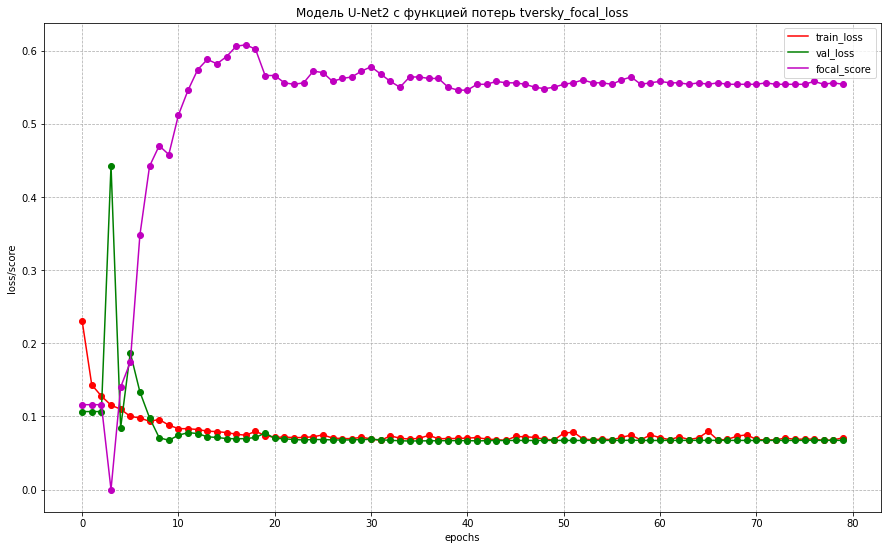

In [62]:
plt.figure(figsize=(15, 9))

plt.plot(unet_train_loss, 'r-', label="train_loss")
plt.plot(unet_train_loss, 'ro')

plt.plot(unet_val_loss, 'g-', label="val_loss")
plt.plot(unet_val_loss, 'go')

plt.plot(unet_iou, 'm-', label="focal_score")
plt.plot(unet_iou, 'mo')

plt.legend(loc='best')
plt.title('Модель U-Net2 c функцией потерь tversky_focal_loss')
plt.xlabel("epochs")
plt.grid(linestyle='--', linewidth=0.75)
plt.ylabel("loss/score")
plt.show()

In [63]:
ALL_DATA_U_NET2['tversky_focal_loss'] =  {
    'train_loss': sum([i.item() for i in unet_train_loss[-10:]])/10,
    'valid_loss': sum([i.item() for i in unet_val_loss[-10:]])/10,
    'iou_metric': sum([i for i in unet_iou[-10:]])/10,
    'time': unet_time
}

Значение score достигает максимума примерно на 15-20 эпохе, после чего идет небольшой спад и выход на плато. Видимо, из-за большого шага модель уходит от качественных параметров

### Обучение модели с функцией потерь focal_loss

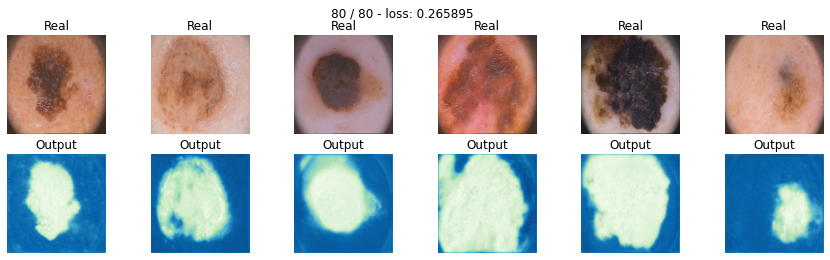

time: 45.298 s
0.7139999866485596


In [64]:
# lr=1e-2 - score=0.4099
# lr=1e-3 - score=0.5099 - gamma=0.1
# lr=1e-3 - score=0.6639 - gamma=0.4
# lr=1e-3 - score=0.6719 - gamma=0.7 - step_size=3
# lr=1e-3 - score=0.6899 - gamma=0.7 - step_size=5
# lr=1e-3 - score=0.6680 - gamma=0.7 - step_size=7
# lr=1e-4 - score=0.1539

import torch.optim as optim

unet2_model = UNet2().to(device)

max_epochs = 80

optimaizer = optim.Adam(unet2_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=5, gamma=0.7)

unet_train_loss, unet_val_loss, unet_iou, unet_time = train(model=unet2_model, 
                                              opt = optimaizer, 
                                              scheduler = scheduler, 
                                              loss_fn = focal_loss, 
                                              epochs = max_epochs, 
                                              data_tr = data_tr, 
                                              data_val = data_val)

print(score_model(unet2_model, iou_pytorch, data_val))

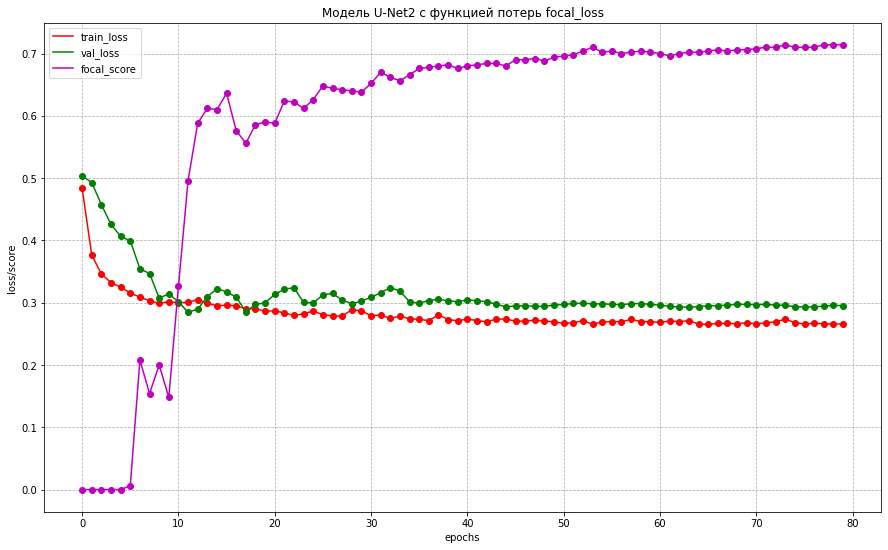

In [65]:
plt.figure(figsize=(15, 9))

plt.plot(unet_train_loss, 'r-', label="train_loss")
plt.plot(unet_train_loss, 'ro')

plt.plot(unet_val_loss, 'g-', label="val_loss")
plt.plot(unet_val_loss, 'go')

plt.plot(unet_iou, 'm-', label="focal_score")
plt.plot(unet_iou, 'mo')

plt.legend(loc='best')
plt.title('Модель U-Net2 c функцией потерь focal_loss')
plt.xlabel("epochs")
plt.grid(linestyle='--', linewidth=0.75)
plt.ylabel("loss/score")
plt.show()

In [66]:
ALL_DATA_U_NET2['focal_loss'] =  {
    'train_loss': sum([i.item() for i in unet_train_loss[-10:]])/10,
    'valid_loss': sum([i.item() for i in unet_val_loss[-10:]])/10,
    'iou_metric': sum([i for i in unet_iou[-10:]])/10,
    'time': unet_time
}

Значение score растет на протяжении всех эпох, однако присутвуют колебания в значениях

### Обучение модели с функцией потерь dice_loss

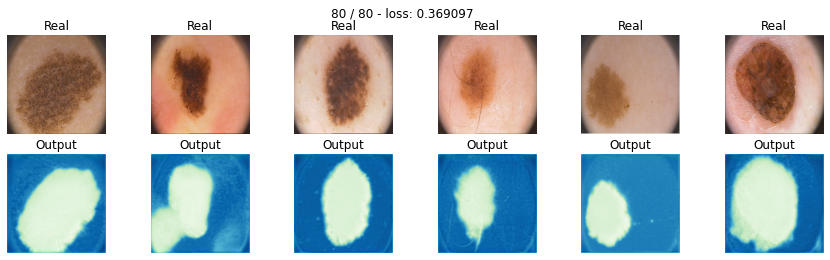

time: 44.790 s
0.6279999613761902


In [67]:
# lr=1e-2 - score=0.5079
# lr=1e-3 - score=0.6340 - gamma=0.1
# lr=1e-3 - score=0.5639 - gamma=0.4- step_size=3
# lr=1e-3 - score=0.6780 - gamma=0.4- step_size=5
# lr=1e-3 - score=0.6379 - gamma=0.4- step_size=7
# lr=1e-3 - score=0.6660 - gamma=0.7
# lr=1e-4 - score=0.1920

import torch.optim as optim

unet2_model = UNet2().to(device)

max_epochs = 80

optimaizer = optim.Adam(unet2_model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.StepLR(optimaizer, step_size=5, gamma=0.4)

unet_train_loss, unet_val_loss, unet_iou, unet_time = train(model=unet2_model, 
                                              opt = optimaizer, 
                                              scheduler = scheduler, 
                                              loss_fn = dice_loss, 
                                              epochs = max_epochs, 
                                              data_tr = data_tr, 
                                              data_val = data_val)

print(score_model(unet2_model, iou_pytorch, data_val))

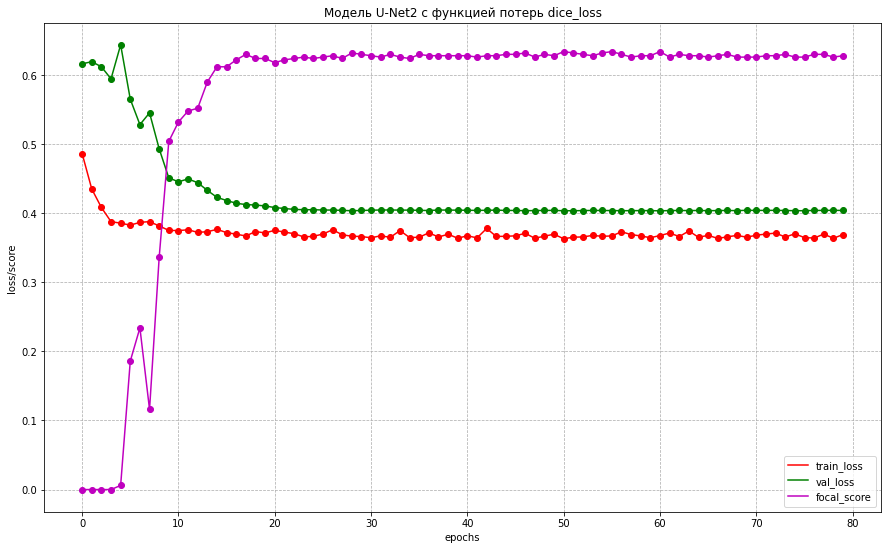

In [68]:
plt.figure(figsize=(15, 9))

plt.plot(unet_train_loss, 'r-', label="train_loss")
plt.plot(unet_train_loss, 'ro')

plt.plot(unet_val_loss, 'g-', label="val_loss")
plt.plot(unet_val_loss, 'go')

plt.plot(unet_iou, 'm-', label="focal_score")
plt.plot(unet_iou, 'mo')

plt.legend(loc='best')
plt.title('Модель U-Net2 c функцией потерь dice_loss')
plt.xlabel("epochs")
plt.grid(linestyle='--', linewidth=0.75)
plt.ylabel("loss/score")
plt.show()

In [69]:
ALL_DATA_U_NET2['dice_loss'] =  {
    'train_loss': sum([i.item() for i in unet_train_loss[-10:]])/10,
    'valid_loss': sum([i.item() for i in unet_val_loss[-10:]])/10,
    'iou_metric': sum([i for i in unet_iou[-10:]])/10,
    'time': unet_time
}

Значение score достигает максимума примерно на 20 эпохе и далее выходит на плато

# Итог по качеству моделей

На каждом графике представлены по 3 модели - SegNet, U-Net, U-Net2, значения которых довольно хорошо различимы. Предлагается интуитивная оценка по данному блоку в 1 балл - за лучшее значение для данного графика (например, наименьшее время обучения или наивысшее значение метрики качества iou_metric), 2 балла - за среднее значение и 3 балла - за наихудшее. По итогу такой разбалловки можно будет предположить какая модель оказалась лучше, с учетом малого объема данных.   
Для более честного "соревнования" бралось среднее значение метрик на последних 10 эпохах.   
Некотрые модели показывают наилучшие значения на малом значении эпох и несколько ухудшают свои показатели при большом. Данное обстоятельство не отражается текущих расчетах в связи со временем сдачи. Это можно исправить записывая для метрик максимальное или минимальное значение на всем периоде обучения.

## Сравнение функций потерь на разных моделях по четырем метрикам

In [70]:
import matplotlib.pyplot as plt

<Figure size 576x864 with 0 Axes>

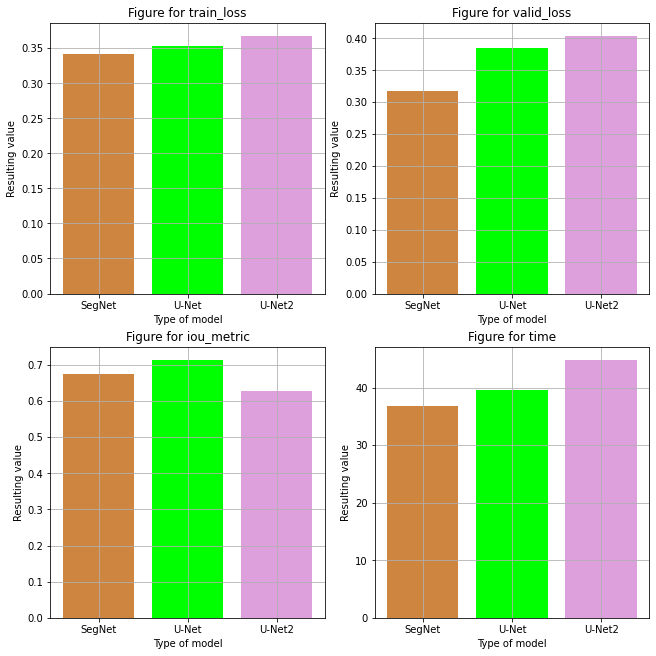

In [71]:
# Функция потерь dice_loss
plt.figure(figsize=(8, 12))
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(9,9))
for ax, i in zip(axs.flat, ['train_loss', 'valid_loss', 'iou_metric', 'time']):
    ax.set_xlabel('Type of model')
    ax.set_ylabel('Resulting value')
    ax.set_title(f"Figure for {i}")
    # ax.set_yticks(range(1, 8))
    ax.grid()
    ax.bar(['SegNet', 'U-Net', 'U-Net2'], 
           [ALL_DATA_SEG_NET['dice_loss'][i], 
            ALL_DATA_U_NET['dice_loss'][i],
            ALL_DATA_U_NET2['dice_loss'][i]], 
           color=['peru', 'lime', 'plum']
           )

<Figure size 576x864 with 0 Axes>

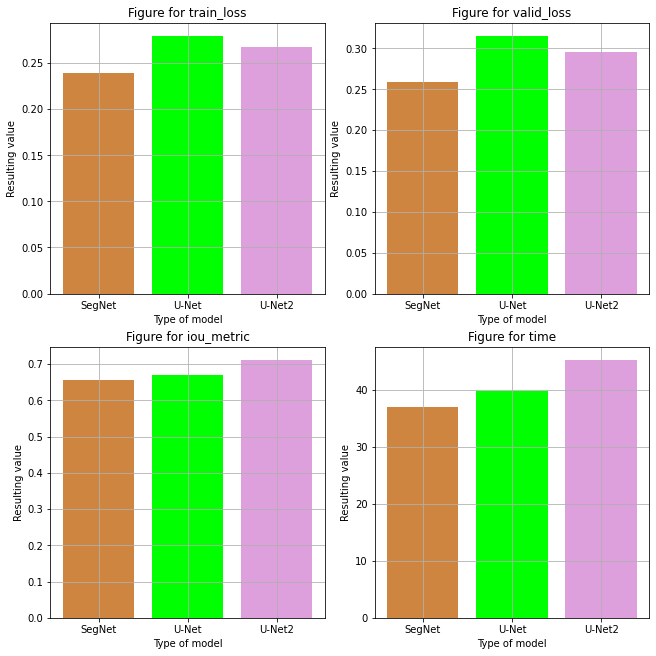

In [72]:
# Функция потерь focal_loss
plt.figure(figsize=(8, 12))
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(9,9))
for ax, i in zip(axs.flat, ['train_loss', 'valid_loss', 'iou_metric', 'time']):
    ax.set_xlabel('Type of model')
    ax.set_ylabel('Resulting value')
    ax.set_title(f"Figure for {i}")
    # ax.set_yticks(range(1, 8))
    ax.grid()
    ax.bar(['SegNet', 'U-Net', 'U-Net2'], 
           [ALL_DATA_SEG_NET['focal_loss'][i], 
            ALL_DATA_U_NET['focal_loss'][i],
            ALL_DATA_U_NET2['focal_loss'][i]], 
           color=['peru', 'lime', 'plum']
           )

<Figure size 576x864 with 0 Axes>

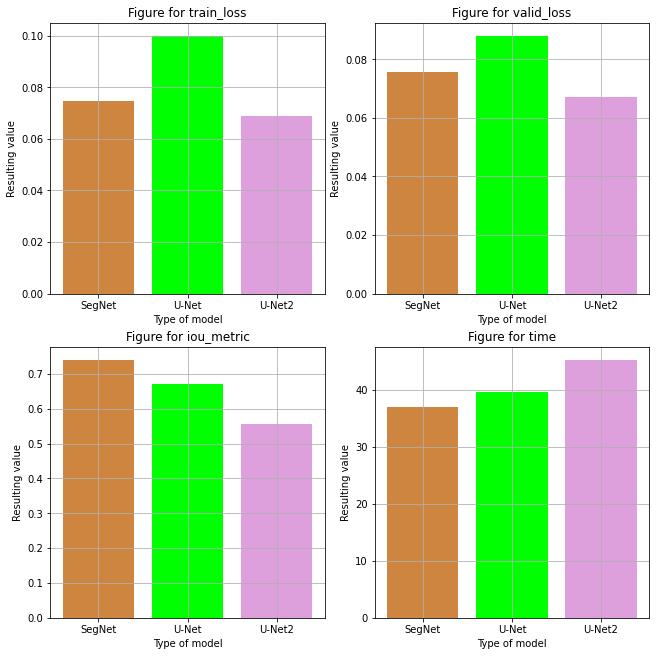

In [73]:
# Функция потерь tversky_focal_loss
plt.figure(figsize=(8, 12))
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(9,9))
for ax, i in zip(axs.flat, ['train_loss', 'valid_loss', 'iou_metric', 'time']):
    ax.set_xlabel('Type of model')
    ax.set_ylabel('Resulting value')
    ax.set_title(f"Figure for {i}")
    # ax.set_yticks(range(1, 8))
    ax.grid()
    ax.bar(['SegNet', 'U-Net', 'U-Net2'], 
           [ALL_DATA_SEG_NET['tversky_focal_loss'][i], 
            ALL_DATA_U_NET['tversky_focal_loss'][i],
            ALL_DATA_U_NET2['tversky_focal_loss'][i]], 
           color=['peru', 'lime', 'plum']
           )

<Figure size 576x864 with 0 Axes>

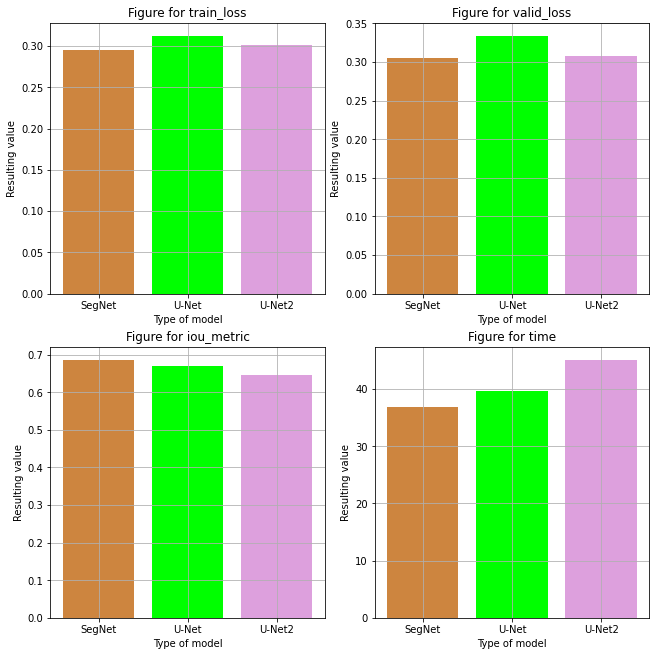

In [74]:
# Функция потерь tversky_loss
plt.figure(figsize=(8, 12))
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(9,9))
for ax, i in zip(axs.flat, ['train_loss', 'valid_loss', 'iou_metric', 'time']):
    ax.set_xlabel('Type of model')
    ax.set_ylabel('Resulting value')
    ax.set_title(f"Figure for {i}")
    # ax.set_yticks(range(1, 8))
    ax.grid()
    ax.bar(['SegNet', 'U-Net', 'U-Net2'], 
           [ALL_DATA_SEG_NET['tversky_loss'][i], 
            ALL_DATA_U_NET['tversky_loss'][i],
            ALL_DATA_U_NET2['tversky_loss'][i]], 
           color=['peru', 'lime', 'plum']
           )

### Выводы

Наименьший лосс на тренировочной и тестовой выборке / наибольшее значение метрики iou_metric / наименьшее время - 1 балл соответственно. Модель с наименьшим суммарным значением побеждает

Функция потерь dice_loss:   
$
\newcommand\T{\Rule{0pt}{1em}{.3em}}
\begin{array}{|c|c|c|c|c|}
\hline mark & train\_loss & valid\_loss & iou\_metric & time \T \\\hline
  1 \T & SegNet & SegNet & U-Net & SegNet \\\hline
  2 \T & U-Net & U-Net & SegNet & U-Net \\\hline
  3 \T & U-Net2 & U-Net2 & U-Net2 & U-Net2 \\\hline
\end{array}
$

SegNet - 5, U-Net - 7, U-Net2 - 12

Функция потерь focal_loss:   
$
\newcommand\T{\Rule{0pt}{1em}{.3em}}
\begin{array}{|c|c|c|c|c|}
\hline mark & train\_loss & valid\_loss & iou\_metric & time \T \\\hline
  1 \T & SegNet & SegNet & U-Net2 & SegNet \\\hline
  2 \T & U-Net2 & U-Net2 & U-Net & U-Net \\\hline
  3 \T & U-Net & U-Net & SegNet & U-Net2 \\\hline
\end{array}
$

SegNet - 11, U-Net - 17, U-Net2 - 20

Функция потерь tversky_focal_loss:   
$
\newcommand\T{\Rule{0pt}{1em}{.3em}}
\begin{array}{|c|c|c|c|c|}
\hline mark & train\_loss & valid\_loss & iou\_metric & time \T \\\hline
  1 \T & U-Net2 & U-Net2  & SegNet & SegNet \\\hline
  2 \T & SegNet & SegNet & U-Net & U-Net \\\hline
  3 \T & U-Net & U-Net & U-Net2 & U-Net2 \\\hline
\end{array}
$

SegNet - 17, U-Net - 27, U-Net2 - 28

Функция потерь tversky_loss:   
$
\newcommand\T{\Rule{0pt}{1em}{.3em}}
\begin{array}{|c|c|c|c|c|}
\hline mark & train\_loss & valid\_loss & iou\_metric & time \T \\\hline
  1 \T & SegNet & SegNet/U-Net2 & SegNet & SegNet \\\hline
  2 \T & U-Net2 & U-Net & U-Net & U-Net \\\hline
  3 \T & U-Net & - & U-Net2 & U-Net2 \\\hline
\end{array}
$

SegNet - 21, U-Net - 36, U-Net2 - 37

Предположение состояло в том, что на первый план выйдет модель ипользующая skip-connection, так как будет более сильная обобщающая способность.

Часть причин способствующая данному итогу указана выше. Дополнительные факторы: малая выборка, не совсем оптимальные параметры в связи рандомным разбиением на обучающую и тестовыую выборку

## Сравнение моделей по четырем метрикам

<Figure size 576x864 with 0 Axes>

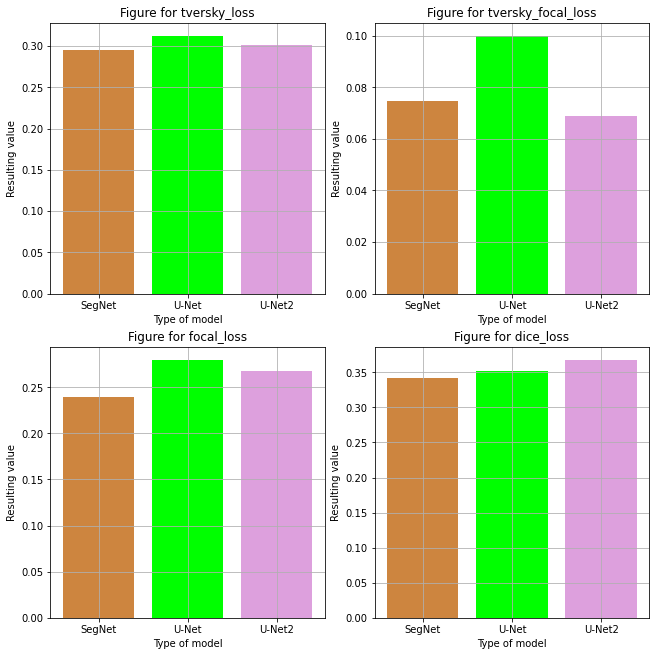

In [75]:
# Метрика для сравнения - train_loss
plt.figure(figsize=(8, 12))
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(9,9))
for ax, i in zip(axs.flat, ['tversky_loss', 'tversky_focal_loss', 'focal_loss', 'dice_loss']):
    ax.set_xlabel('Type of model')
    ax.set_ylabel('Resulting value')
    ax.set_title(f"Figure for {i}")
    # ax.set_yticks(range(1, 8))
    ax.grid()
    ax.bar(['SegNet', 'U-Net', 'U-Net2'], 
           [ALL_DATA_SEG_NET[i]['train_loss'], 
            ALL_DATA_U_NET[i]['train_loss'],
            ALL_DATA_U_NET2[i]['train_loss']], 
           color=['peru', 'lime', 'plum']
           )

<Figure size 576x864 with 0 Axes>

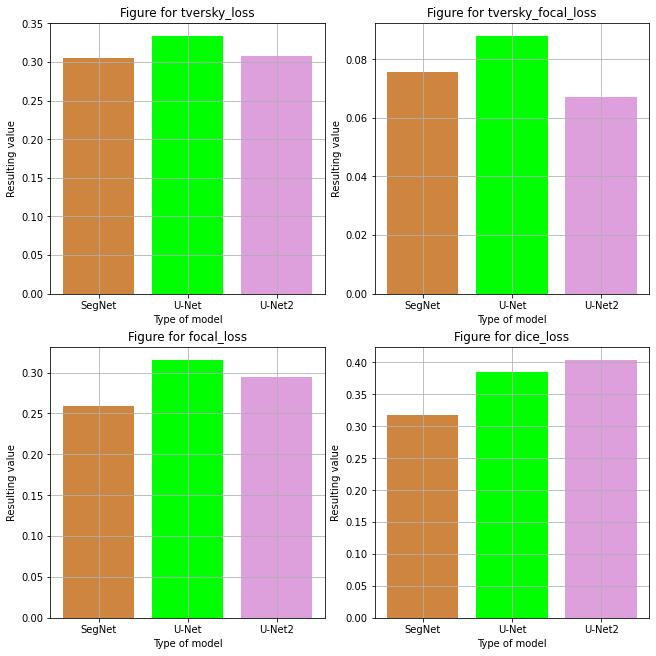

In [76]:
# Метрика для сравнения - valid_loss
plt.figure(figsize=(8, 12))
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(9,9))
for ax, i in zip(axs.flat, ['tversky_loss', 'tversky_focal_loss', 'focal_loss', 'dice_loss']):
    ax.set_xlabel('Type of model')
    ax.set_ylabel('Resulting value')
    ax.set_title(f"Figure for {i}")
    # ax.set_yticks(range(1, 8))
    ax.grid()
    ax.bar(['SegNet', 'U-Net', 'U-Net2'], 
           [ALL_DATA_SEG_NET[i]['valid_loss'], 
            ALL_DATA_U_NET[i]['valid_loss'],
            ALL_DATA_U_NET2[i]['valid_loss']], 
           color=['peru', 'lime', 'plum']
           )

<Figure size 576x864 with 0 Axes>

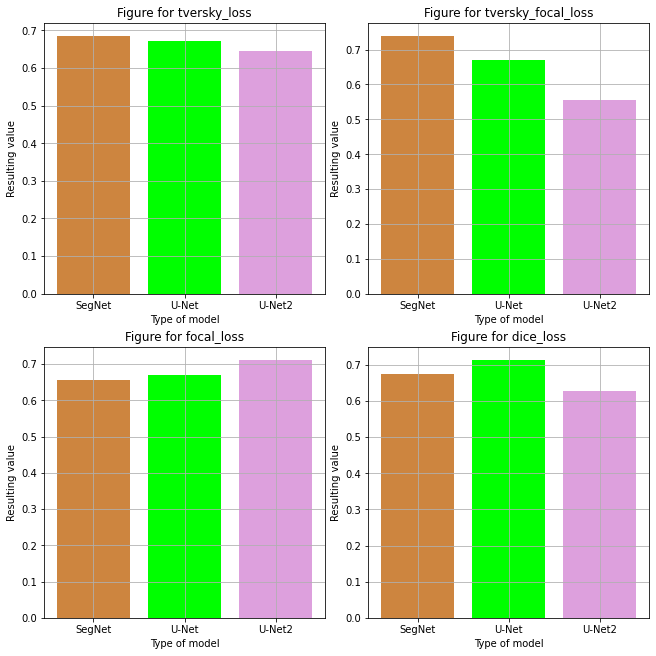

In [77]:
# Метрика для сравнения - iou_metric
plt.figure(figsize=(8, 12))
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(9,9))
for ax, i in zip(axs.flat, ['tversky_loss', 'tversky_focal_loss', 'focal_loss', 'dice_loss']):
    ax.set_xlabel('Type of model')
    ax.set_ylabel('Resulting value')
    ax.set_title(f"Figure for {i}")
    # ax.set_yticks(range(1, 8))
    ax.grid()
    ax.bar(['SegNet', 'U-Net', 'U-Net2'], 
           [ALL_DATA_SEG_NET[i]['iou_metric'], 
            ALL_DATA_U_NET[i]['iou_metric'],
            ALL_DATA_U_NET2[i]['iou_metric']], 
           color=['peru', 'lime', 'plum']
           )

<Figure size 576x864 with 0 Axes>

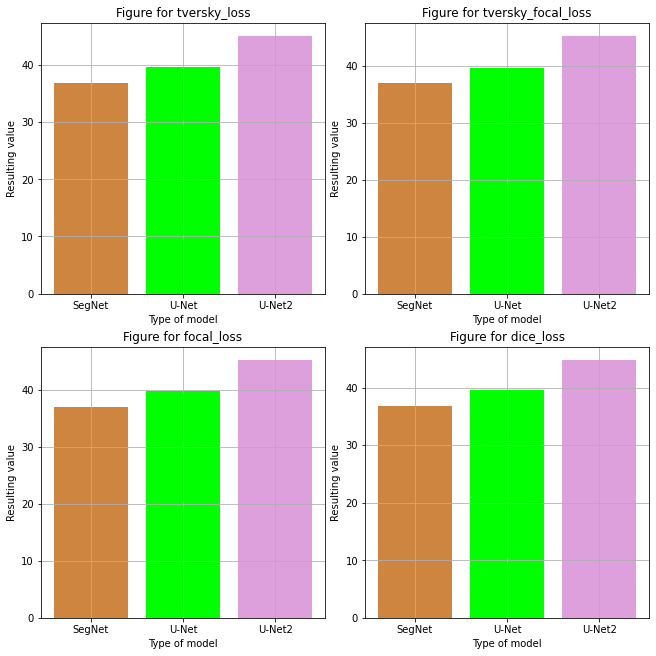

In [78]:
# Метрика для сравнения - time
plt.figure(figsize=(8, 12))
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(9,9))
for ax, i in zip(axs.flat, ['tversky_loss', 'tversky_focal_loss', 'focal_loss', 'dice_loss']):
    ax.set_xlabel('Type of model')
    ax.set_ylabel('Resulting value')
    ax.set_title(f"Figure for {i}")
    # ax.set_yticks(range(1, 8))
    ax.grid()
    ax.bar(['SegNet', 'U-Net', 'U-Net2'], 
           [ALL_DATA_SEG_NET[i]['time'], 
            ALL_DATA_U_NET[i]['time'],
            ALL_DATA_U_NET2[i]['time']], 
           color=['peru', 'lime', 'plum']
           )

### Выводы

Если попытаться сравнивать метрики, то лучше всего посмотреть на график iou_metric. Более стабильные значения для моделей у метрики focal_loss

Сделайте вывод, какая из моделей лучше

Ожидание: лучшая модель U-Net   
Рельаность: лучшая модель SegNet

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.